In [1]:
import os
import pickle
import sys
import numpy as np
import scipy
import scipy.io
import math
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
np.random.seed(123)

In [2]:
if not os.path.exists('qm7.mat'):
    os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')

## Modeling

In [3]:
class SortedNorm:
    def __init__(self, total_atom = 23):
        self.total_atom = total_atom
        self.max_num_atom = 1
        self.triuind =  (np.arange(23)[:, np.newaxis] <= np.arange(23)[
                        np.newaxis, :]).flatten()

    def featurize(self, z):
        ids = np.argsort((z ** 2).sum(axis = 0) ** 0.5)
        ids = ids[::-1]
        z = z[ids, :][:, ids]
        z = z.flatten()[self.triuind]
        return z 

    def process(self, X):
        features = np.array([self.featurize(z) for z in X])
        return features

In [4]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    mse = np.square(np.subtract(y_true,y_pred)).mean() 
    return math.sqrt(mse)

In [6]:
def cross_validation(dataset, featurizer):
    mae_scores = []
    rmse_scores = []
    for split in [0,1,2,3,4]:
        best_mae_score = 1000
        best_rmse_score = 1000
        best_sigma = -1
        best_alpha = 0
        P_train = dataset['P'][list(range(0, split))+list(range(split+1, 5))].flatten()
        P_test = dataset['P'][split]
    
        X_train = dataset['X'][P_train]
        T_train = dataset['T'][0, P_train]

        X_test = dataset['X'][P_test]
        T_test = dataset['T'][0, P_test]
        
        
        x_train = featurizer.process(X_train)
        y_train = T_train
        
        x_test = featurizer.process(X_test)
        y_test = T_test
        
        for sigma in [50, 74, 100, 1000]:
            gamma = 1.0/(2*sigma**2)
            for alpha in [0.001, 0.0001, 0.02, 0.002]:
                model = KernelRidge(gamma=gamma, kernel="rbf", alpha=alpha).fit(x_train, y_train)
        
            y_pred = model.predict(x_test)
        
            mae_score = mae(y_test, y_pred)
            rmse_score = rmse(y_test, y_pred)

            if best_mae_score > mae_score:
                best_mae_score = mae_score
                best_rmse_score = rmse_score 
                best_sigma = sigma 
                best_alpha = alpha

        
        print("Split: ", split)
        print("MAE: ", best_mae_score)
        print("RMSE: ", best_rmse_score)
        print("Alpha: ", best_alpha)
        print("Gamma: ", best_sigma)
        print()

        mae_scores.append(best_mae_score)
        rmse_scores.append(best_rmse_score) 

    mae_scores = np.array(mae_scores)
    rmse_scores = np.array(rmse_scores) 

    mean_mae = mae_scores.mean()
    mean_rmse = rmse_scores.mean()

    std_mae = mae_scores.std()
    std_rmse = rmse_scores.std()

    print("Mean MAE: ", mean_mae)
    print("Std MAE: ", std_mae)

    print("Mean RMSE: ", mean_rmse)
    print("Std RMSE: ", std_rmse)

In [7]:
featurizer = SortedNorm()

In [7]:
cross_validation(dataset, featurizer)

Split:  0
MAE:  8.748115
RMSE:  12.39375994783388
Alpha:  0.002
Gamma:  50

Split:  1
MAE:  9.154412
RMSE:  13.344139361451962
Alpha:  0.002
Gamma:  50

Split:  2
MAE:  8.428669
RMSE:  11.299629434906745
Alpha:  0.002
Gamma:  50

Split:  3
MAE:  9.522646
RMSE:  13.713932520995927
Alpha:  0.002
Gamma:  50

Split:  4
MAE:  8.826446
RMSE:  12.617360438056295
Alpha:  0.002
Gamma:  50

Mean MAE:  8.936058
Std MAE:  0.37324128
Mean RMSE:  12.673764340648962
Std RMSE:  0.8368014234363536


## Visualization

In [ ]:
X = dataset['X']
Y = dataset['T']

In [ ]:
featurizer = SortedNorm()

In [ ]:
X = featurizer.process(X)

In [ ]:
pca = PCA(n_components = 2)
x = pca.fit_transform(X)

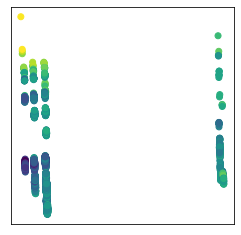

In [ ]:
plt.figure(figsize = (4,4))
plt.scatter(x[:, 0], x[:, 1], c = Y)
plt.xticks([])
plt.yticks([])
plt.savefig("sorted_norm.pdf")
plt.show()